In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* Rename this notebook as PRENOM_NOM_TP_DISTILLATION.ipynb
* Delivery deadline is March the 14th


**Fact that wil be helpful for the exercise**. Given a Neural Network architecture

```
inputs = Input(shape=input_shape)
y = Conv2D(filters=64, kernel_size=kernel_size, activation='relu', padding='same')(inputs)
y = Conv2D(filters=64, kernel_size=kernel_size, activation='relu', padding='same')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=32, kernel_size=kernel_size, activation='relu', padding='same')(y)
output_1 = Conv2D(filters=32, kernel_size=kernel_size, activation='relu', padding='same')(y)
y = MaxPooling2D()(output_1)
y = Conv2D(filters=32, kernel_size=kernel_size, activation='relu', padding='same')(y)
y = Flatten()(y)
y = Dense(10)(y)
output_2 = Activation('softmax')(y)
```
We can define two different models by specifying input and output. For instance


```
model_1 = Model(inputs=inputs, outputs=output_1)
model_2 = Model(inputs=inputs, outputs=output_2)
```
Moreover, if we compile both models and, say, we train model_1, then the weights of model_2 that are shared with model_1 will be learned too.





# Data preparation
1. Download the [CIFAR10 dataset](https://keras.io/api/datasets/cifar10/).
2. Rescale images between 0 and 1.
3. Apply a one-hot encoding to labels of both train and test dataset.

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical


# Load the CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Rescale images between 0 and 1 (on divise par 255)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Apply one-hot encoding to labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)





In [ ]:
x_train.shape

(50000, 32, 32, 3)

[texte du lien](https://)# Hinton distillation

Define the Teacher Neural Network: this has 16 convolutional layers built with the [Keras functional API](https://keras.io/guides/functional_api/), with kernel size equal to 3; the number of filters starts from 256 and is divided by 2 every 4 layers; add also MaxPooling layers every 4 convolutional layers. Activation function is the ReLU and padding has to be 'same'.
the Teacher Net architecture has **two outputs** that bifurcate right after the last dense layer: 
1. the 'normal' output is made of a Softmax activation;
2. the 'heated' output is made of a [Lambda layer](https://keras.io/api/layers/core_layers/lambda/) + a Softmax activation. The parameter $\tau$ (the temperature) can be chosen in the interval (1, 10).

In [ ]:
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
# from tensorflow.keras.models import Model
# import tensorflow.keras.backend as K

# # Define input shape
# input_shape = (32, 32, 3)

# # Define temperature
# tau = 1

# # Define input layer
# inputs = Input(shape=input_shape)

# # Initialize number of filters
# num_filters = 256

# # Add 16 convolutional layers with decreasing number of filters

# x = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(inputs)

# for i in range(1,16):
#     x = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(x)
#     # Add MaxPooling every 4 convolutional layers
#     if (i+1) % 4 == 0:
#         x = MaxPooling2D((2, 2))(x)
        
#     # Decrease number of filters every 4 convolutional layers
#     if (i+1) % 4 == 0 and i != 15:
#         num_filters = num_filters/2
        
# # Flatten output of last convolutional layer
# x = Flatten()(x)

# # Add dense layer
# x = Dense(256, activation='relu')(x)

# # Define normal output with Softmax activation
# normal_output = Dense(10, activation='softmax', name='normal_output')(x)

# # Define heated output with Lambda layer and Softmax activation
# heated_output = Lambda(lambda x: x / tau)(x)
# heated_output = Dense(10, activation='softmax', name='heated_output')(heated_output)

# # Define Teacher Net model
# teacher = Model(inputs=inputs, outputs=[normal_output, heated_output])


from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Activation
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def define_teacher_net(input_shape, tau):
    # Define input layer
    inputs = Input(shape=input_shape)

    # Initialize number of filters
    num_filters = 256

    # Add 16 convolutional layers with decreasing number of filters
    x = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(inputs)

    for i in range(1, 16):
        x = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(x)
        # Add MaxPooling every 4 convolutional layers
        if (i+1) % 3 == 0 and i != 15:
            x = MaxPooling2D((2, 2))(x)

        # Decrease number of filters every 4 convolutional layers
        if (i+1) % 3 == 0 and i != 15:
            num_filters = num_filters / 2

    # Flatten output of last convolutional layer
    x = Flatten()(x)

    # Add dense layer
    x = Dense(256, activation='relu')(x)

    # Define normal output with Softmax activation
    normal_output = Dense(10, activation='softmax', name='normal_teacher')(x)

    # Define heated output with Lambda layer and Softmax activation

    #On teste et on remet ces 2 lignes
    #heated_output = Lambda(lambda x: x / tau)(x)
    #heated_output = Dense(10, activation='softmax', name='heated_teacher')(heated_output)

    #heated_output = Dense(10, name='heated_teacher')(x)
    #Ca je l'ai ajouté
    heated_output = Dense(10, name='heated_teacher')(x)
    heated_output = Lambda(lambda x: K.softmax(x / tau))(heated_output)


    # Define Teacher Net model
    teacher = Model(inputs=inputs, outputs=[normal_output, heated_output], name='Teacher_Net')
    
    return teacher


def compile_teacher_net(teacher):
    # Compile Teacher Net model
    teacher.compile(loss=['categorical_crossentropy','categorical_crossentropy'],
                    optimizer='adam',
                    metrics=['accuracy'])
    
    return teacher





In [ ]:
# Define input shape
input_shape = (32, 32, 3)

# Define temperature
tau = 1

# Define Teacher Net model
teacher = define_teacher_net(input_shape, tau)

# Compile Teacher Net model
teacher = compile_teacher_net(teacher)

In [ ]:
print(teacher.summary())

\Initialize both models with the 'normal' output and the 'heated' output, by 

---

naming them respectively normal_teacher and heated_teacher.



In [ ]:
#len(teacher.get_weights())

In [ ]:
import keras
# Create new model for normal output using pre-trained weights of Teacher Net
normal_teacher = Model(inputs=teacher.input, outputs=teacher.get_layer('normal_teacher').output, name='normal_teacher')

# Create new model for heated output using pre-trained weights of Teacher Net
heated_teacher = Model(inputs=teacher.input, outputs=teacher.get_layer('heated_teacher').output, name='heated_teacher')

# Clone student for later comparison
normal_teacher_scratch = keras.models.clone_model(normal_teacher)

# Print summary of normal_teacher and heated_teacher models
print("Summary of normal_teacher:")
print(normal_teacher.summary())




In [ ]:
#Summary of heated teacher
print("Summary of heated_teacher:")
print(heated_teacher.summary())

Compile **both** normal_teacher and heated_teacher by choosing a categorical crossentropy loss, Adam optimizer and accuracy metrics.

In [ ]:
def compile_normal(normal_teacher):
    # Compile Teacher Net model
    normal_teacher.compile(loss=['categorical_crossentropy'],
                    optimizer='adam',
                    metrics=['accuracy'])
    
    return normal_teacher

def compile_heated(heated_teacher):
    # Compile Teacher Net model
    heated_teacher.compile(loss=['categorical_crossentropy'],
                    optimizer='adam',
                    metrics=['accuracy'])
    
    return heated_teacher


In [ ]:
# Compile normal_Teacher Net model
normal_teacher = compile_normal(normal_teacher)
heated_teacher = compile_heated(heated_teacher)

Train the Teacher Net with normal output using an appropriate [data augmentation](https://keras.io/zh/examples/cifar10_resnet/) strategy; it might be helpful to reduce the learning rate programmatically with the callback   [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/). Write few lines to comment the choice you made.



In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

batch_size = 128
epochs = 8

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0.1,  # set range for random shear
    zoom_range=0.2,  # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None)


datagen.fit(x_train)


# Train Teacher Net model with normal output
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.00001)

# history = teacher.fit(train_datagen.flow(x_train, [y_train, y_train], batch_size=batch_size),
#                       steps_per_epoch=len(x_train) / batch_size, epochs=epochs,
#                       validation_data=(x_val, [y_val, y_val]), callbacks=[reduce_lr])



history1 = teacher.fit(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4, callbacks=[reduce_lr])



Epoch 1/8
391/391 [==============================] - 67s 141ms/step - loss: 4.6053 - normal_teacher_loss: 2.3026 - lambda_1_loss: 2.3027 - normal_teacher_accuracy: 0.0994 - lambda_1_accuracy: 0.0967 - val_loss: 4.6052 - val_normal_teacher_loss: 2.3026 - val_lambda_1_loss: 2.3026 - val_normal_teacher_accuracy: 0.1000 - val_lambda_1_accuracy: 0.1000 - lr: 0.0010
Epoch 2/8
391/391 [==============================] - 52s 132ms/step - loss: 4.6054 - normal_teacher_loss: 2.3027 - lambda_1_loss: 2.3027 - normal_teacher_accuracy: 0.0982 - lambda_1_accuracy: 0.0987 - val_loss: 4.6052 - val_normal_teacher_loss: 2.3026 - val_lambda_1_loss: 2.3026 - val_normal_teacher_accuracy: 0.1000 - val_lambda_1_accuracy: 0.1000 - lr: 0.0010
Epoch 3/8
391/391 [==============================] - 52s 131ms/step - loss: 4.6054 - normal_teacher_loss: 2.3027 - lambda_1_loss: 2.3027 - normal_teacher_accuracy: 0.0991 - lambda_1_accuracy: 0.0978 - val_loss: 4.6052 - val_normal_teacher_loss: 2.3026 - val_lambda_1_loss: 2

To obtain y_train_heated and y_test_heated, simply 

1.   Élément de liste
2.   Élément de liste

run a predict of the heated_teacher on x_train and x_test.

In [ ]:
y_train_heated = heated_teacher.predict(x_train)
y_test_heated = heated_teacher.predict(x_test)


313/313 [==============================] - 3s 10ms/step


The Student architecture we will be using, much smaller than the Teacher, can be found here below:

In [ ]:
kernel_size = (3, 3)
inputs = Input(shape=input_shape)
y = Conv2D(filters=64, kernel_size=kernel_size, activation='relu', padding='same')(inputs)
y = Conv2D(filters=64, kernel_size=kernel_size, activation='relu', padding='same')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=32, kernel_size=kernel_size, activation='relu', padding='same')(y)
y = Conv2D(filters=32, kernel_size=kernel_size, activation='relu', padding='same')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=32, kernel_size=kernel_size, activation='relu', padding='same')(y)
y = Flatten()(y)
y = Dense(10)(y)
normal_output = Activation('softmax', name="normal_output")(y)

First of all, we want to asses the performance of this base Student model with no guidance. For this you should 
1. initialize the model (you can name it base_student), 
2. compile it with categorical crossentropy loss, Adam optimizer, accuracy metric,
3. train it for 25 epochs with no data augmentation.

In [ ]:
base_student = Model(inputs=inputs, outputs=normal_output)

In [ ]:
base_student.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
base_student.fit(x_train, y_train, batch_size=128, epochs=25, validation_data=(x_test, y_test))


Epoch 1/25
391/391 [==============================] - 9s 18ms/step - loss: 1.6270 - accuracy: 0.4113 - val_loss: 1.3498 - val_accuracy: 0.5129
Epoch 2/25
391/391 [==============================] - 6s 15ms/step - loss: 1.2115 - accuracy: 0.5674 - val_loss: 1.1655 - val_accuracy: 0.5926
Epoch 3/25
391/391 [==============================] - 6s 15ms/step - loss: 1.0231 - accuracy: 0.6393 - val_loss: 0.9538 - val_accuracy: 0.6669
Epoch 4/25
391/391 [==============================] - 6s 15ms/step - loss: 0.8790 - accuracy: 0.6912 - val_loss: 0.8887 - val_accuracy: 0.6909
Epoch 5/25
391/391 [==============================] - 6s 15ms/step - loss: 0.7897 - accuracy: 0.7254 - val_loss: 0.8202 - val_accuracy: 0.7185
Epoch 6/25
391/391 [==============================] - 6s 15ms/step - loss: 0.7177 - accuracy: 0.7487 - val_loss: 0.8130 - val_accuracy: 0.7176
Epoch 7/25
391/391 [==============================] - 6s 14ms/step - loss: 0.6644 - accuracy: 0.7692 - val_loss: 0.7837 - val_accuracy: 0.7307

As you did with the Teacher Net, you should add a heated output to the Student Net, made of a Lambda layer + Softmax activation. This new student_distilled model has two outputs (normal and heated) and can be trained with x_train and supervised with both y_train and y_train_heated. [Here](https://stackoverflow.com/questions/44036971/multiple-outputs-in-keras) you can find how to initialize a Keras model with multiple outputs. In our case both outputs require a categorical crossentropy and accuracy metric.

In [ ]:
temperature = 5.0

heated_logits = Lambda(lambda x: x / temperature)(y)

heated_output = Activation('softmax', name="heated_output")(heated_logits)


student_distilled = Model(inputs=inputs, outputs=[normal_output, heated_output])


You can now train the two-outputs student_distilled model that leverages the Teacher heated output. To do this, you have to
1. choose a categorical crossentropy loss, Adam optimizer and accuracy metric for both outputs,
2. train it for 25 epochs with no data augmentation.

You can choose the temperature parameter τ such that  3 < τ < 8.

---


Comment the results. 

In [ ]:
from keras.optimizers import Adam

# Compile the model with two losses and the Adam optimizer
student_distilled.compile(
    loss=['categorical_crossentropy', 'categorical_crossentropy'],
    optimizer=Adam(),
    metrics=['accuracy'])

# Train the model for 25 epochs with no data augmentation
history = student_distilled.fit(
    x_train, [y_train, y_train_heated],
    batch_size=128,
    epochs=16,
    validation_data=(x_test, [y_test, y_test_heated])
)



Epoch 1/16
391/391 [==============================] - 7s 17ms/step - loss: 5658838016.0000 - normal_output_loss: 5673001472.0000 - heated_output_loss: -14162108.0000 - normal_output_accuracy: 0.1675 - heated_output_accuracy: 0.0927 - val_loss: 56662671360.0000 - val_normal_output_loss: 56811466752.0000 - val_heated_output_loss: -148805312.0000 - val_normal_output_accuracy: 0.1468 - val_heated_output_accuracy: 0.4552
Epoch 2/16
391/391 [==============================] - 6s 16ms/step - loss: 901988155392.0000 - normal_output_loss: 904303738880.0000 - heated_output_loss: -2315351040.0000 - normal_output_accuracy: 0.1274 - heated_output_accuracy: 0.0937 - val_loss: 2613990129664.0000 - val_normal_output_loss: 2619891515392.0000 - val_heated_output_loss: -5901368320.0000 - val_normal_output_accuracy: 0.1055 - val_heated_output_accuracy: 0.9634
Epoch 3/16
391/391 [==============================] - 6s 16ms/step - loss: 12917098414080.0000 - normal_output_loss: 12951654236160.0000 - heated_out

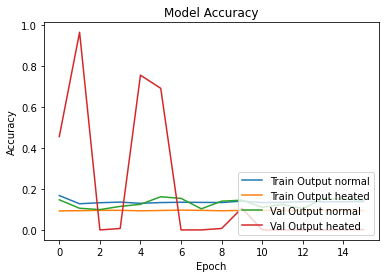

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy for each output
plt.plot(history.history['normal_output_accuracy'])
plt.plot(history.history['heated_output_accuracy'])
plt.plot(history.history['val_normal_output_accuracy'])
plt.plot(history.history['val_heated_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Output normal', 'Train Output heated', 'Val Output normal', 'Val Output heated'], loc='lower right')
plt.show()


# Intermediate supervision

In this section we will add an extra supervision coming from one of the intermediate convolutional layers. 
1. The first thing to do is to pick, from the Teacher Net you defined above, an intermediate hint layer (e.g. the first conv layer with 64 filters);
2. then we can initialize a new hint_teacher model which has, as output, this hint layer. 
3. Compile the hint_teacher model
4. train once again the normal_teacher model as you did above.
5. As before, run a prediction of the x_train x_test with the heated_teacher (to obtain y_train_heated and y_test_heated) and the hint_teacher (to obtain y_train_hint and y_test_hint).

In [ ]:
print(teacher.summary())

Model: "Teacher_Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 256)  7168        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 256)  590080      ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 32, 256)  590080      ['conv2d_1[0][0]']               
                                                                                        

In [ ]:
teacher_model = teacher

hint_layer = teacher_model.layers[8] 

hint_teacher = Model(inputs=teacher_model.input, outputs=hint_layer.output)
hint_teacher.compile(loss='accuracy', optimizer='adam')



In [ ]:
#base_student.fit(x_train, y_train, batch_size=64, epochs=32, validation_data=(x_test, y_test))

history2 = teacher.fit(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4, callbacks=[reduce_lr])


NameError: ignored

In [ ]:
y_train_heated = heated_teacher.predict(x_train)
y_test_heated = heated_teacher.predict(x_test)

y_train_hint = hint_teacher.predict(x_train)
y_test_hint = hint_teacher.predict(x_test)

Now we can deal with the Student Net: 
1. its guided intermediate layer will be the convolutional layer with 32 filters
2. add, after this guided layer, another convolutional layer with 64 filters (the same shape of the Teacher Net hint layer!).
3. Initialize this guided_student model and compile it with mean squared error loss and mean squared error metric.

The training stage is done in two steps:
1. we train the guided_student model (i.e. the bottom part of the student model) with y_train_hint, the ouput of the hint teacher layer.
2. after that, we can train the distilled_student model exactly the same way you did in the first section. 